In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

from src.gis_global_module import run_global_analysis, preprocess_data

In [2]:
# Assuming the script is in the src directory, set the script_dir accordingly
script_dir = Path(os.getcwd()).resolve()
repo_root = script_dir.parent
results_dir = repo_root / "results"

# Define paths relative to the src directory
URB_DATA_FILE = repo_root / "data" / "GIS" / "gis_data_adm1.csv"
URB_DATA_FILE_SAMPLE = repo_root / "data" / "GIS" / "GIS_data_zones_sample.csv"
COUNTRY_DATA_FILE = repo_root / "data" / "processed" / "merged_data.csv"

In [3]:
# Load data
merged_data = pd.read_csv(COUNTRY_DATA_FILE)
df_zones_input = pd.read_csv(URB_DATA_FILE)

/tmp/ipykernel_27752/3657333345.py:3: DtypeWarning: Columns (37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zones_input = pd.read_csv(URB_DATA_FILE)


First, run the global model to get our calculated water access

/workspaces/water-access/src/gis_global_module.py:136: DtypeWarning: Columns (37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zones_input = pd.read_csv(urb_data_file)




 1 


222


/workspaces/water-access/src/gis_global_module.py:1277: RuntimeWarning: invalid value encountered in double_scalars
  df_districts["percent_piped_with_only_cycling_access"] = (
/workspaces/water-access/src/gis_global_module.py:1070: UserWarning: Input dataframe contains NaN values
  warnings.warn("Input dataframe contains NaN values")
/workspaces/water-access/src/gis_global_module.py:1127: RuntimeWarning: invalid value encountered in double_scalars
  df_countries["percent_piped_with_only_cycling_access"] = (


Countries removed from analysis due to being further than Libya's median: ['Cook Islands', 'Comoros', 'Cabo Verde', 'Cayman Islands', 'Mayotte', 'Niue', 'French Polynesia', 'Saint Helena, Ascension and Tristan da Cunha']
Countries removed manually: ['GUM', 'ASM', 'TON', 'MNP', 'ATG', 'DMA', 'ABW', 'BRB']


 5 


174
185


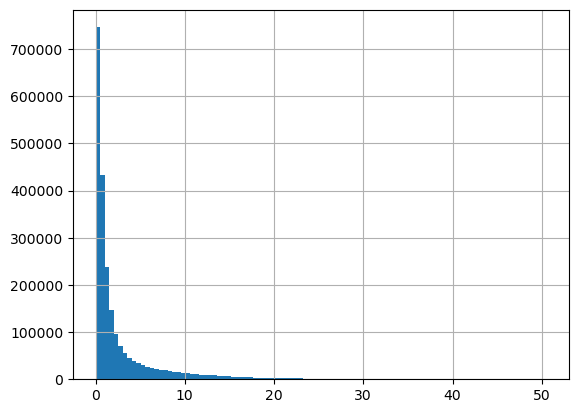

In [4]:
# test null case
# If time gathering water is 0, percentage of population without water access
# should be equal to percentage piped

df_countries, df_districts = run_global_analysis(
    crr_adjustment=0,
    time_gathering_water=0,
    practical_limit_bicycle=40,
    practical_limit_buckets=20,
    met=4.5,
    watts=75,
    hill_polarity="flat_uphill",
    urban_adjustment=1.345,
    rural_adjustment=1.2,
    calculate_distance=True,
    plot=False,
    human_mass=62,  # gets overridden by country specific weight
    use_sample_data=False,
)

Next, without running the model, calculate our piped and unpiped calculations from our categorization of zones as urban or rural

/workspaces/water-access/src/gis_global_module.py:136: DtypeWarning: Columns (37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zones_input = pd.read_csv(urb_data_file)


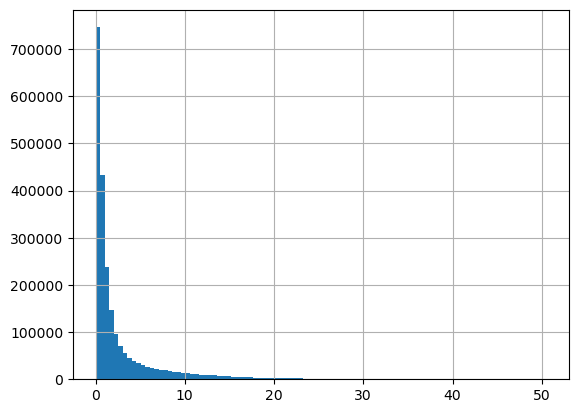

In [5]:
# Preprocess as in gis_global_module
df_zones = preprocess_data(
    crr_adjustment=0,
    urban_adjustment=1,
    rural_adjustment=1,
    use_sample_data=False,
)

# Calculate piped and unpiped populations for each grid cell
df_zones = df_zones[
    [
        "ISOCODE",
        "NAME0",
        "urban_rural",
        "RURALPiped",
        "URBANPiped",
        "% urban",
        "pop_zone",
        "country_pop_raw",
    ]
]

df_zones["zone_pop_piped"] = 0

df_zones["zone_pop_piped"] = (
    df_zones["pop_zone"]
    * df_zones["urban_rural"]
    * df_zones["URBANPiped"]
    / 100
    + df_zones["pop_zone"]
    * (1 - df_zones["urban_rural"])
    * df_zones["RURALPiped"]
    / 100
)
df_zones["zone_pop_unpiped"] = (
    df_zones["pop_zone"]
    * df_zones["urban_rural"]
    * (100 - df_zones["URBANPiped"])
    / 100
    + df_zones["pop_zone"]
    * (1 - df_zones["urban_rural"])
    * (100 - df_zones["RURALPiped"])
    / 100
)

# Group grid cells by country and calculate percentage of population with piped/unpiped
df_calculated_piped = (
    df_zones.groupby("ISOCODE")
    .agg(
        {
            "NAME0": "first",
            "zone_pop_piped": "sum",
            "zone_pop_unpiped": "sum",
            "country_pop_raw": "first",
        }
    )
    .reset_index()
)

df_calculated_piped["calculated_piped"] = (
    df_calculated_piped["zone_pop_piped"]
    / df_calculated_piped["country_pop_raw"]
    * 100
)
df_calculated_piped["calculated_unpiped"] = (
    df_calculated_piped["zone_pop_unpiped"]
    / df_calculated_piped["country_pop_raw"]
    * 100
)

# drop countries that are not in the model output
df_calculated_piped = df_calculated_piped[
    df_calculated_piped["ISOCODE"].isin(df_countries["ISOCODE"])
]

In [6]:
df_calculated_piped[df_calculated_piped["calculated_piped"] == 0]
# df_calculated_piped

,ISOCODE,NAME0,zone_pop_piped,zone_pop_unpiped,country_pop_raw,calculated_piped,calculated_unpiped


In [7]:
# Calculate MAPE between percent_without_water and national piped
# Extract the true (national data), calculated, and predicted values
y_true = df_countries["NATPiped"]
y_calc = df_calculated_piped["calculated_piped"]
y_pred = df_countries["percent_without_water"]
y_true, y_calc, y_pred = np.array(y_true), np.array(y_calc), np.array(y_pred)

mape_true = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_calc = np.mean(np.abs((y_calc - y_pred) / y_true)) * 100

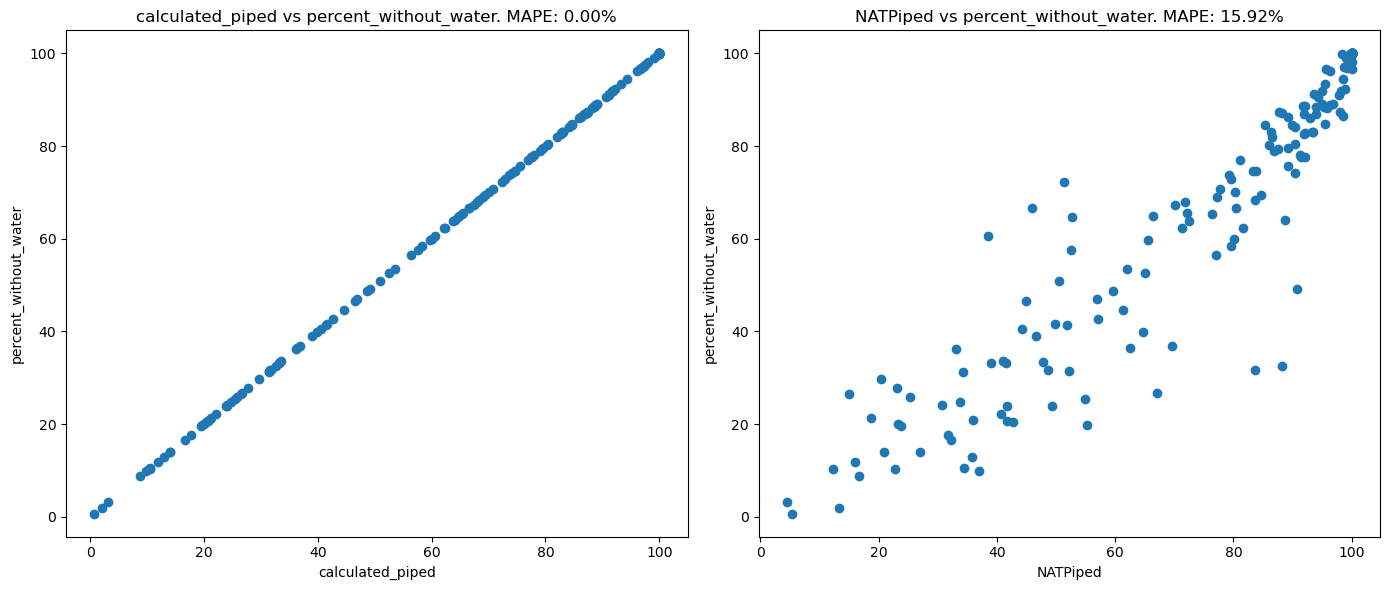

In [8]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: calculated_piped vs percent_without_water
axs[0].scatter(y_calc, y_pred)
axs[0].set_xlabel("calculated_piped")
axs[0].set_ylabel("percent_without_water")
axs[0].set_title(
    f"calculated_piped vs percent_without_water. MAPE: {mape_calc:.2f}%"
)

# Second subplot: true vs predicted
axs[1].scatter(y_true, y_pred)
axs[1].set_xlabel("NATPiped")
axs[1].set_ylabel("percent_without_water")
axs[1].set_title(f"NATPiped vs percent_without_water. MAPE: {mape_true:.2f}%")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()